# <center> **Environment Sound Classification using Deep Learning**


# **Introduction**


## Importing the required modules


In [1]:
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import os, time, warnings
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)

warnings.filterwarnings("ignore")


In [2]:
log_cols = ["model", "accuracy", "train_time", "pred_time"]
log = pd.DataFrame(columns=log_cols)


## Reading the data


In [3]:
# reading the files
audio_dataset_path = "../Audio-Classification-Deep-Learning-main"

# loading the csv
meta_data = pd.read_csv("../Audio-Classification-Deep-Learning-main/UrbanSound8K.csv")
meta_data["class"] = meta_data["class"].replace(
    to_replace="air_conditioner", value="Air Conditioner"
)
meta_data["class"] = meta_data["class"].replace(to_replace="car_horn", value="Car Horn")
meta_data["class"] = meta_data["class"].replace(
    to_replace="children_playing", value="Children Playing"
)
meta_data["class"] = meta_data["class"].replace(to_replace="dog_bark", value="Dog Bark")
meta_data["class"] = meta_data["class"].replace(to_replace="drilling", value="Drilling")
meta_data["class"] = meta_data["class"].replace(
    to_replace="engine_idling", value="Engine Idling"
)
meta_data["class"] = meta_data["class"].replace(to_replace="gun_shot", value="Gun Shot")
meta_data["class"] = meta_data["class"].replace(
    to_replace="jackhammer", value="Jackhammer"
)
meta_data["class"] = meta_data["class"].replace(to_replace="siren", value="Siren")
meta_data["class"] = meta_data["class"].replace(
    to_replace="street_music", value="Street Music"
)
meta_data.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,Dog Bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,Children Playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,Children Playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,Children Playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,Children Playing


In [4]:
meta_data.groupby("classID")["class"].unique()


classID
0     [Air Conditioner]
1            [Car Horn]
2    [Children Playing]
3            [Dog Bark]
4            [Drilling]
5       [Engine Idling]
6            [Gun Shot]
7          [Jackhammer]
8               [Siren]
9        [Street Music]
Name: class, dtype: object

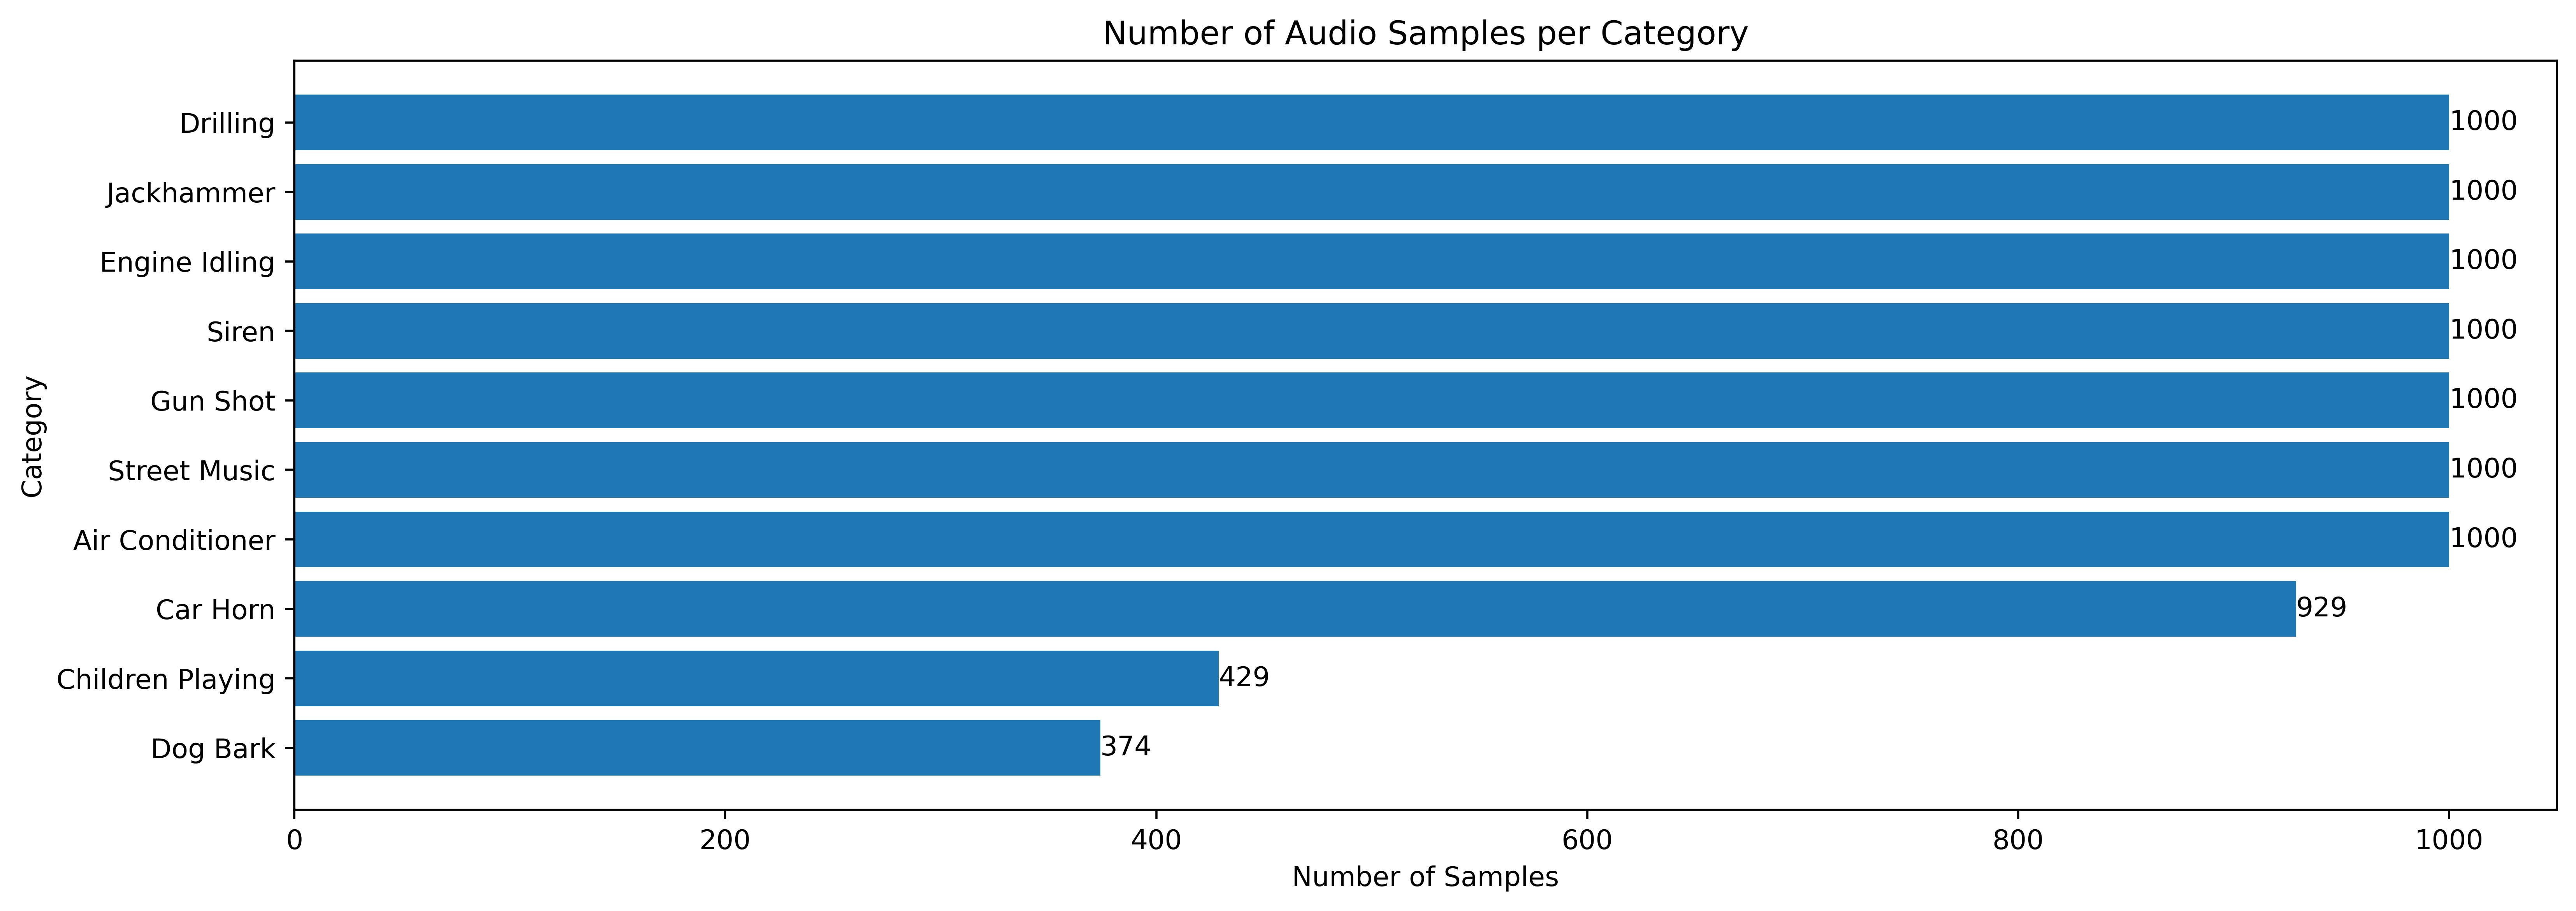

In [5]:
x = meta_data["class"].unique()
y = meta_data["class"].value_counts(ascending=True)
ind = np.arange(len(y))
# plt.figure()
fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(ind, y)
ax.set_yticks(ind)
ax.set_yticklabels(x)
ax.bar_label(ax.containers[0])
plt.gcf().set_dpi(500)
plt.title("Number of Audio Samples per Category")
plt.xlabel("Number of Samples")
plt.ylabel("Category")
plt.show()


# **MFCC Visualization**


In [6]:
plt.rcParams["figure.figsize"] = (4, 5)
plt.rcParams["figure.dpi"] = 200 


<function matplotlib.pyplot.show(close=None, block=None)>

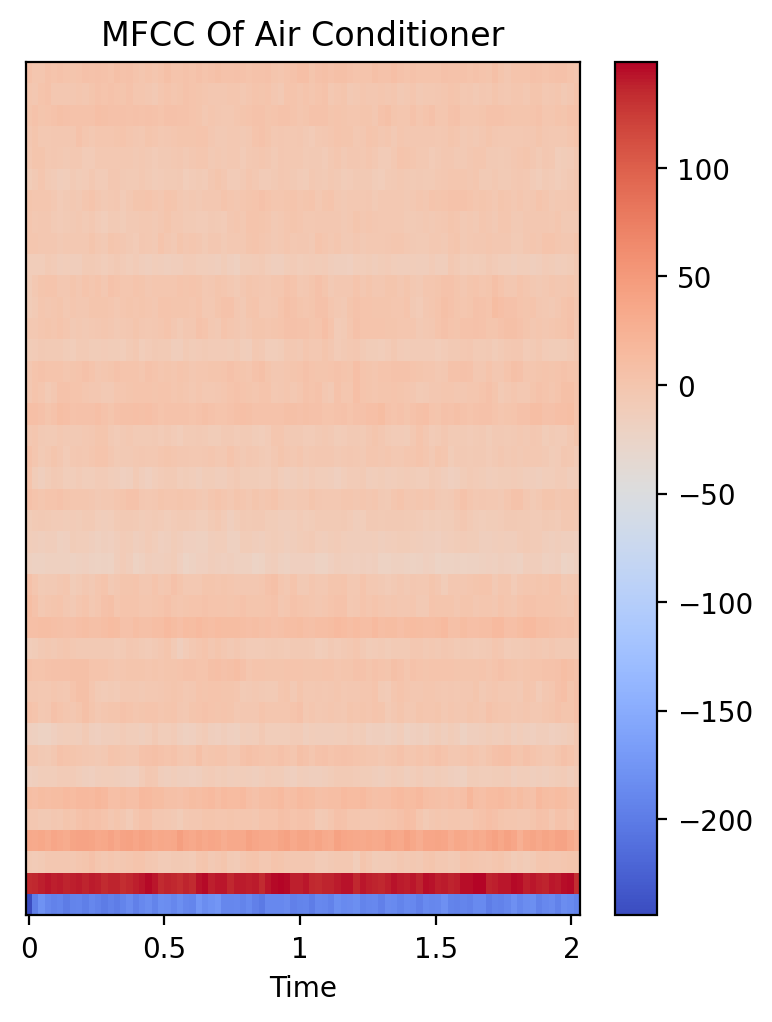

In [7]:
audio_path = audio_dataset_path + "./fold1/127873-0-0-0.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Air Conditioner")
plt.show




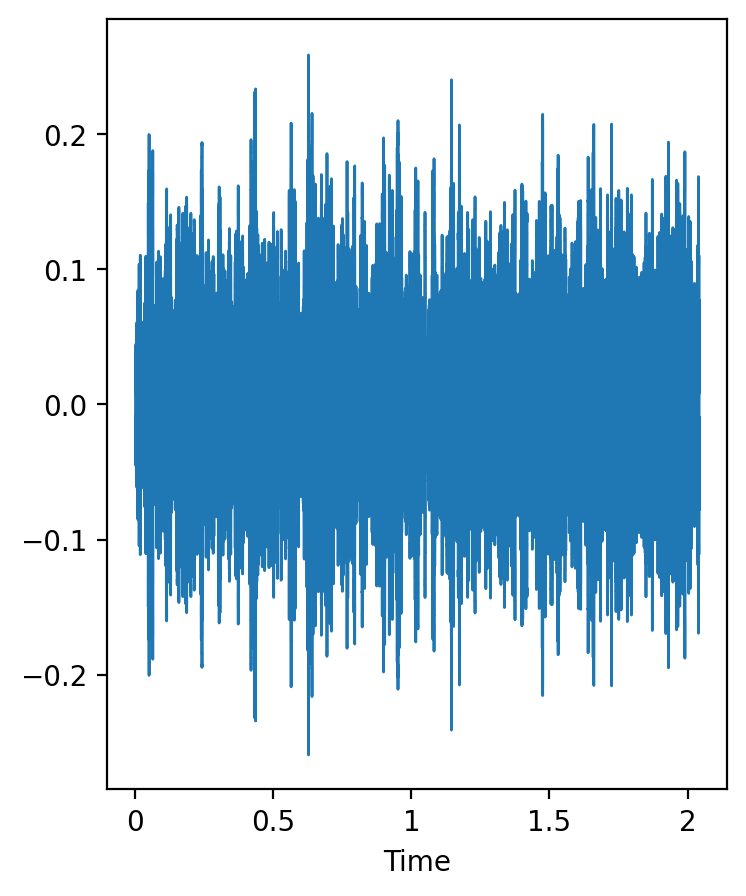

In [8]:
audio_path = audio_dataset_path + "./fold1/127873-0-0-0.wav"
x, freq = librosa.load(audio_path)
librosa.display.waveshow(x, sr=freq)
ipd.Audio(audio_path)


<function matplotlib.pyplot.show(close=None, block=None)>

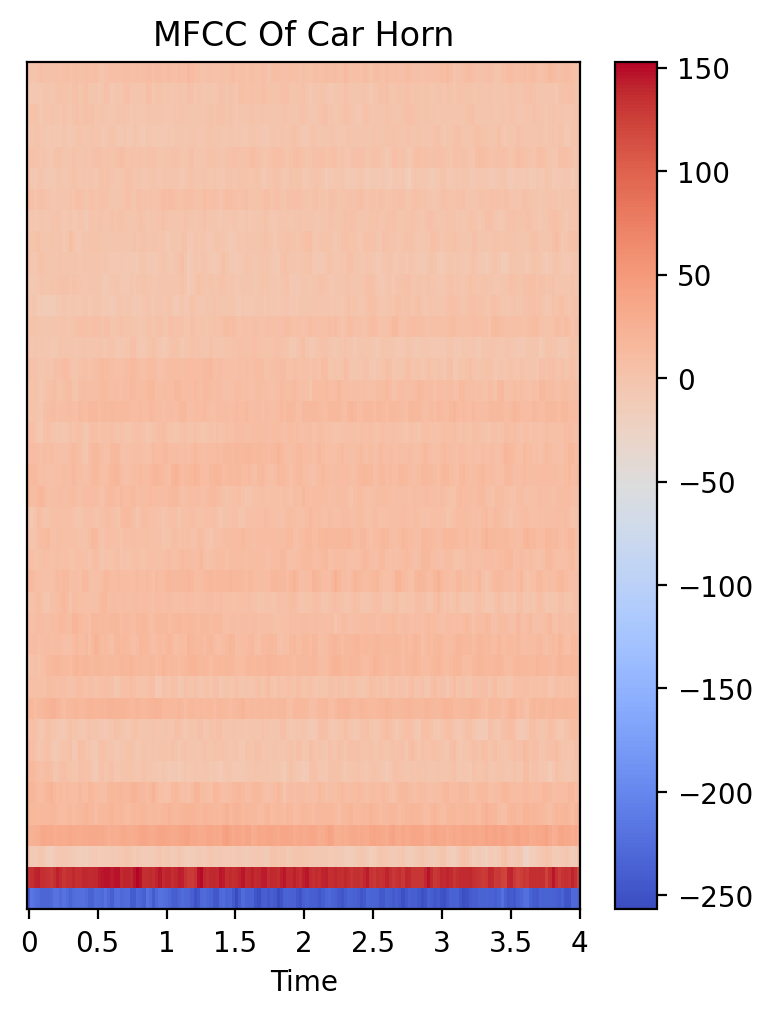

In [9]:
audio_path = audio_dataset_path + "./fold1/17592-5-1-0.wav"
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of Car Horn")
plt.show


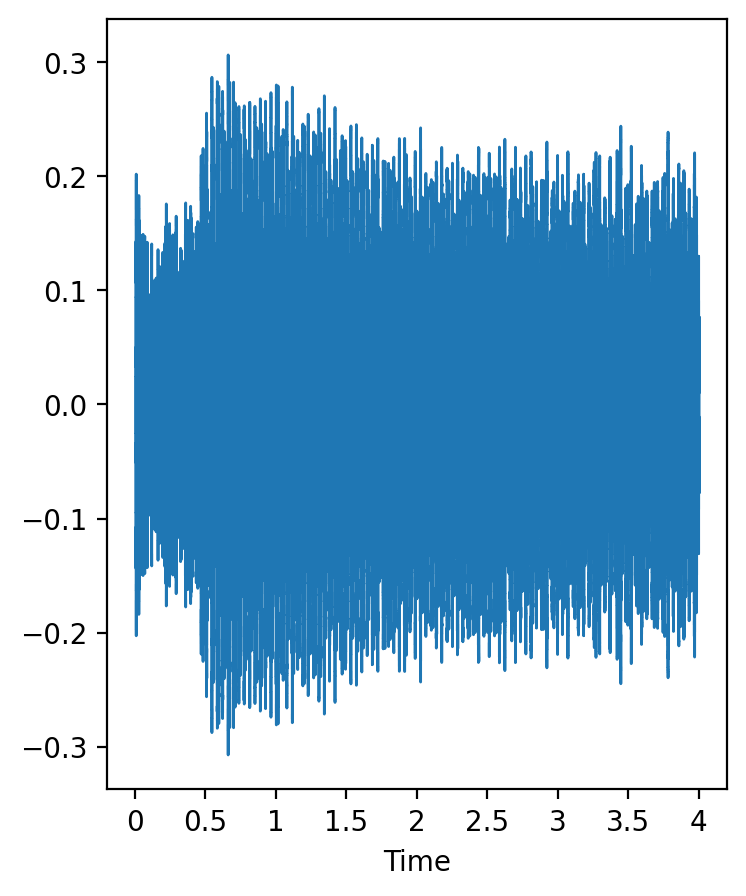

In [10]:
audio_path = audio_dataset_path +"./fold1/17592-5-1-0.wav"
x, freq = librosa.load(audio_path)
librosa.display.waveshow(x, sr=freq)
ipd.Audio(audio_path)

# **Feature Extraction and Database Building**

## Method

1. I have used Librosa to preprocess audio file.
2. To do so, I will go through each fold and extract the data from each file using librosa's mfcc function.
3. The extracted data is appended in a list and stored in a dataframe.

### The function bellow will extract mfcc feature

In [11]:
# list containing all the features
extracted = []

# for each row in the csv
for index_num, row in tqdm(meta_data.iterrows()):
    # get the file
    file_name = os.path.join(
        os.path.abspath(audio_dataset_path),
        "fold" + str(row["fold"]) + "/",
        str(row["slice_file_name"]),
    )
    # get file label
    final_class_labels = row["class"]
    # load the audio file
    audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    # extract the features
    feature = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    # feature scaling
    scaled_feature = np.mean(feature.T, axis=0)
    # store it in a list
    extracted.append([scaled_feature, final_class_labels])

0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\deves\\Desktop\\Training\\Environmental Sound Classification 1.1\\Audio-Classification-Deep-Learning-main\\fold5/100032-3-0-0.wav'

### Using a dataframe and pickle to save the extracted features array


In [7]:
# create a new dataframe
extracted_df = pd.DataFrame(extracted, columns=["feature", "class"])
# Storing the dataframe to pickle for further processing
extracted_df.to_pickle("extracted_df.pkl")
extracted_df.head()


,feature,class


# **Data Preprocessing**


## Distribute the data to X and Y


In [64]:
final = pd.read_pickle("extracted_df.pkl")
X = np.array(final["feature"].tolist())
y = np.array(final["class"].tolist())


## Using LabelEncoder() to encode the string labels to an integer


In [65]:
# label encoding to get encoding
le = LabelEncoder()

# transform each category with it's respected label
Y = to_categorical(le.fit_transform(y))


## Split the data into train and test sets


In [66]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])


Number of training samples =  6985
Number of testing samples =  1747


# **Model 1 - CNN1D**


## Preprocessing


In [67]:
xTrainval, xTest, yTrainval, yTest = train_test_split(
    X, Y, test_size=0.1, stratify=y, random_state=387
)
xTrain, xvalid, yTrain, yvalid = train_test_split(
    xTrainval, yTrainval, test_size=0.2, stratify=yTrainval, random_state=387
)
print("\nNumber of samples for Train set :", xTrain.shape[0])
print("Number of samples for Validation set :", xvalid.shape[0])
print("Number of samples for Test set :", xTest.shape[0])

xTrain = np.expand_dims(xTrain, axis=2)
xvalid = np.expand_dims(xvalid, axis=2)

print("Shape of X Train", xTrain.shape)
print("Shape of X Test", xTest.shape)



Number of samples for Train set : 6286
Number of samples for Validation set : 1572
Number of samples for Test set : 874
Shape of X Train (6286, 128, 1)
Shape of X Test (874, 128)


## Building the CNN1D Model


In [68]:
CNN1D_Model = Sequential()
CNN1D_Model.add(
    Conv1D(
        256,
        5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(xTrain.shape[1], 1),
    )
)
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=10, activation="softmax"))
CNN1D_Model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 128, 256)          1536      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 256)          1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 64, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 64, 256)           327936    
                                                                 
 dropout_4 (Dropout)         (None, 64, 256)           0         
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 32, 256)          

## Compiling the Model


In [69]:
CNN1D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


## Fitting the Model


In [70]:
t0 = time.time()

CNN1D_Results = CNN1D_Model.fit(
    xTrain, yTrain, batch_size=64, epochs=25, validation_data=(xvalid, yvalid)
)

CNN1D_Model.save("Model2.h5")
print("CNN1D Model Saved")
train_hist_m2 = pd.DataFrame(CNN1D_Results.history)
train_m2 = round(time.time() - t0, 3)


Epoch 1/25
99/99 [==============================] - 48s 471ms/step - loss: 1.8143 - accuracy: 0.3667 - val_loss: 1.5433 - val_accuracy: 0.5108
Epoch 2/25
99/99 [==============================] - 51s 518ms/step - loss: 1.2804 - accuracy: 0.5450 - val_loss: 1.2723 - val_accuracy: 0.6120
Epoch 3/25
99/99 [==============================] - 64s 649ms/step - loss: 1.0703 - accuracy: 0.6238 - val_loss: 1.0473 - val_accuracy: 0.7106
Epoch 4/25
99/99 [==============================] - 48s 483ms/step - loss: 0.9003 - accuracy: 0.6818 - val_loss: 0.9403 - val_accuracy: 0.7207
Epoch 5/25
99/99 [==============================] - 50s 508ms/step - loss: 0.8099 - accuracy: 0.7165 - val_loss: 0.7975 - val_accuracy: 0.7735
Epoch 6/25
99/99 [==============================] - 45s 455ms/step - loss: 0.7501 - accuracy: 0.7412 - val_loss: 0.7353 - val_accuracy: 0.7824
Epoch 7/25
99/99 [==============================] - 46s 467ms/step - loss: 0.7046 - accuracy: 0.7588 - val_loss: 0.7643 - val_accuracy: 0.8034

## Results


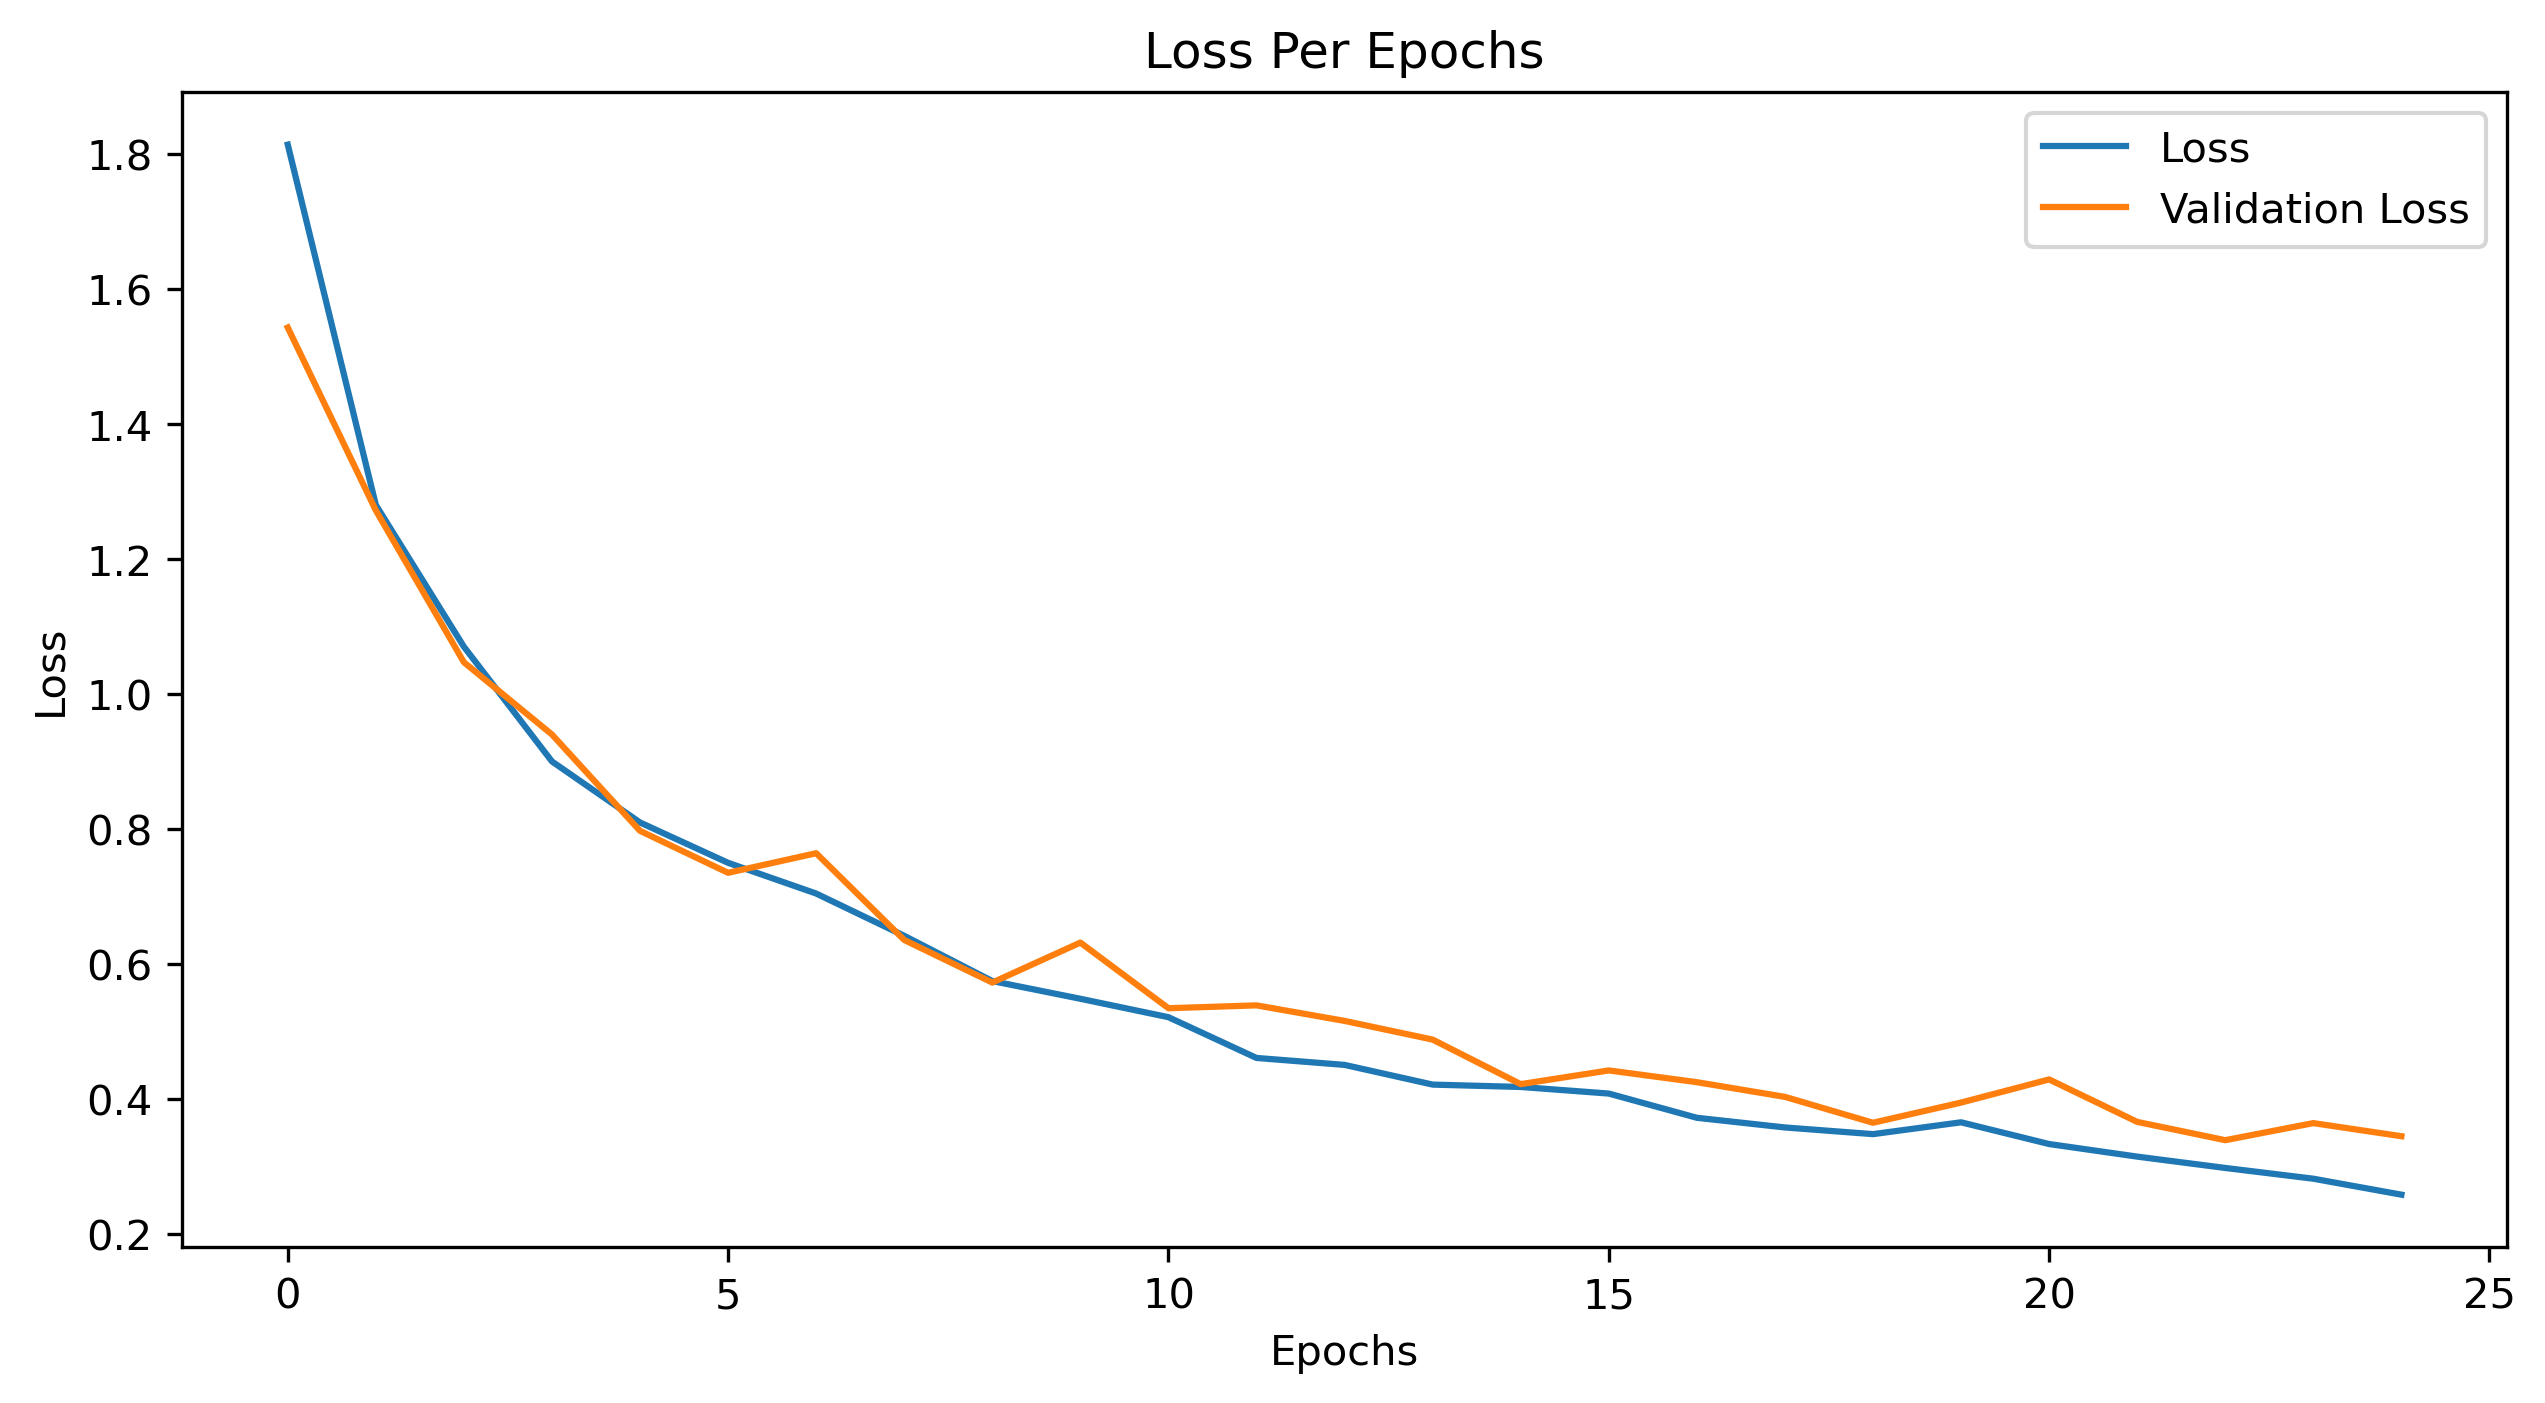

In [71]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m2[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


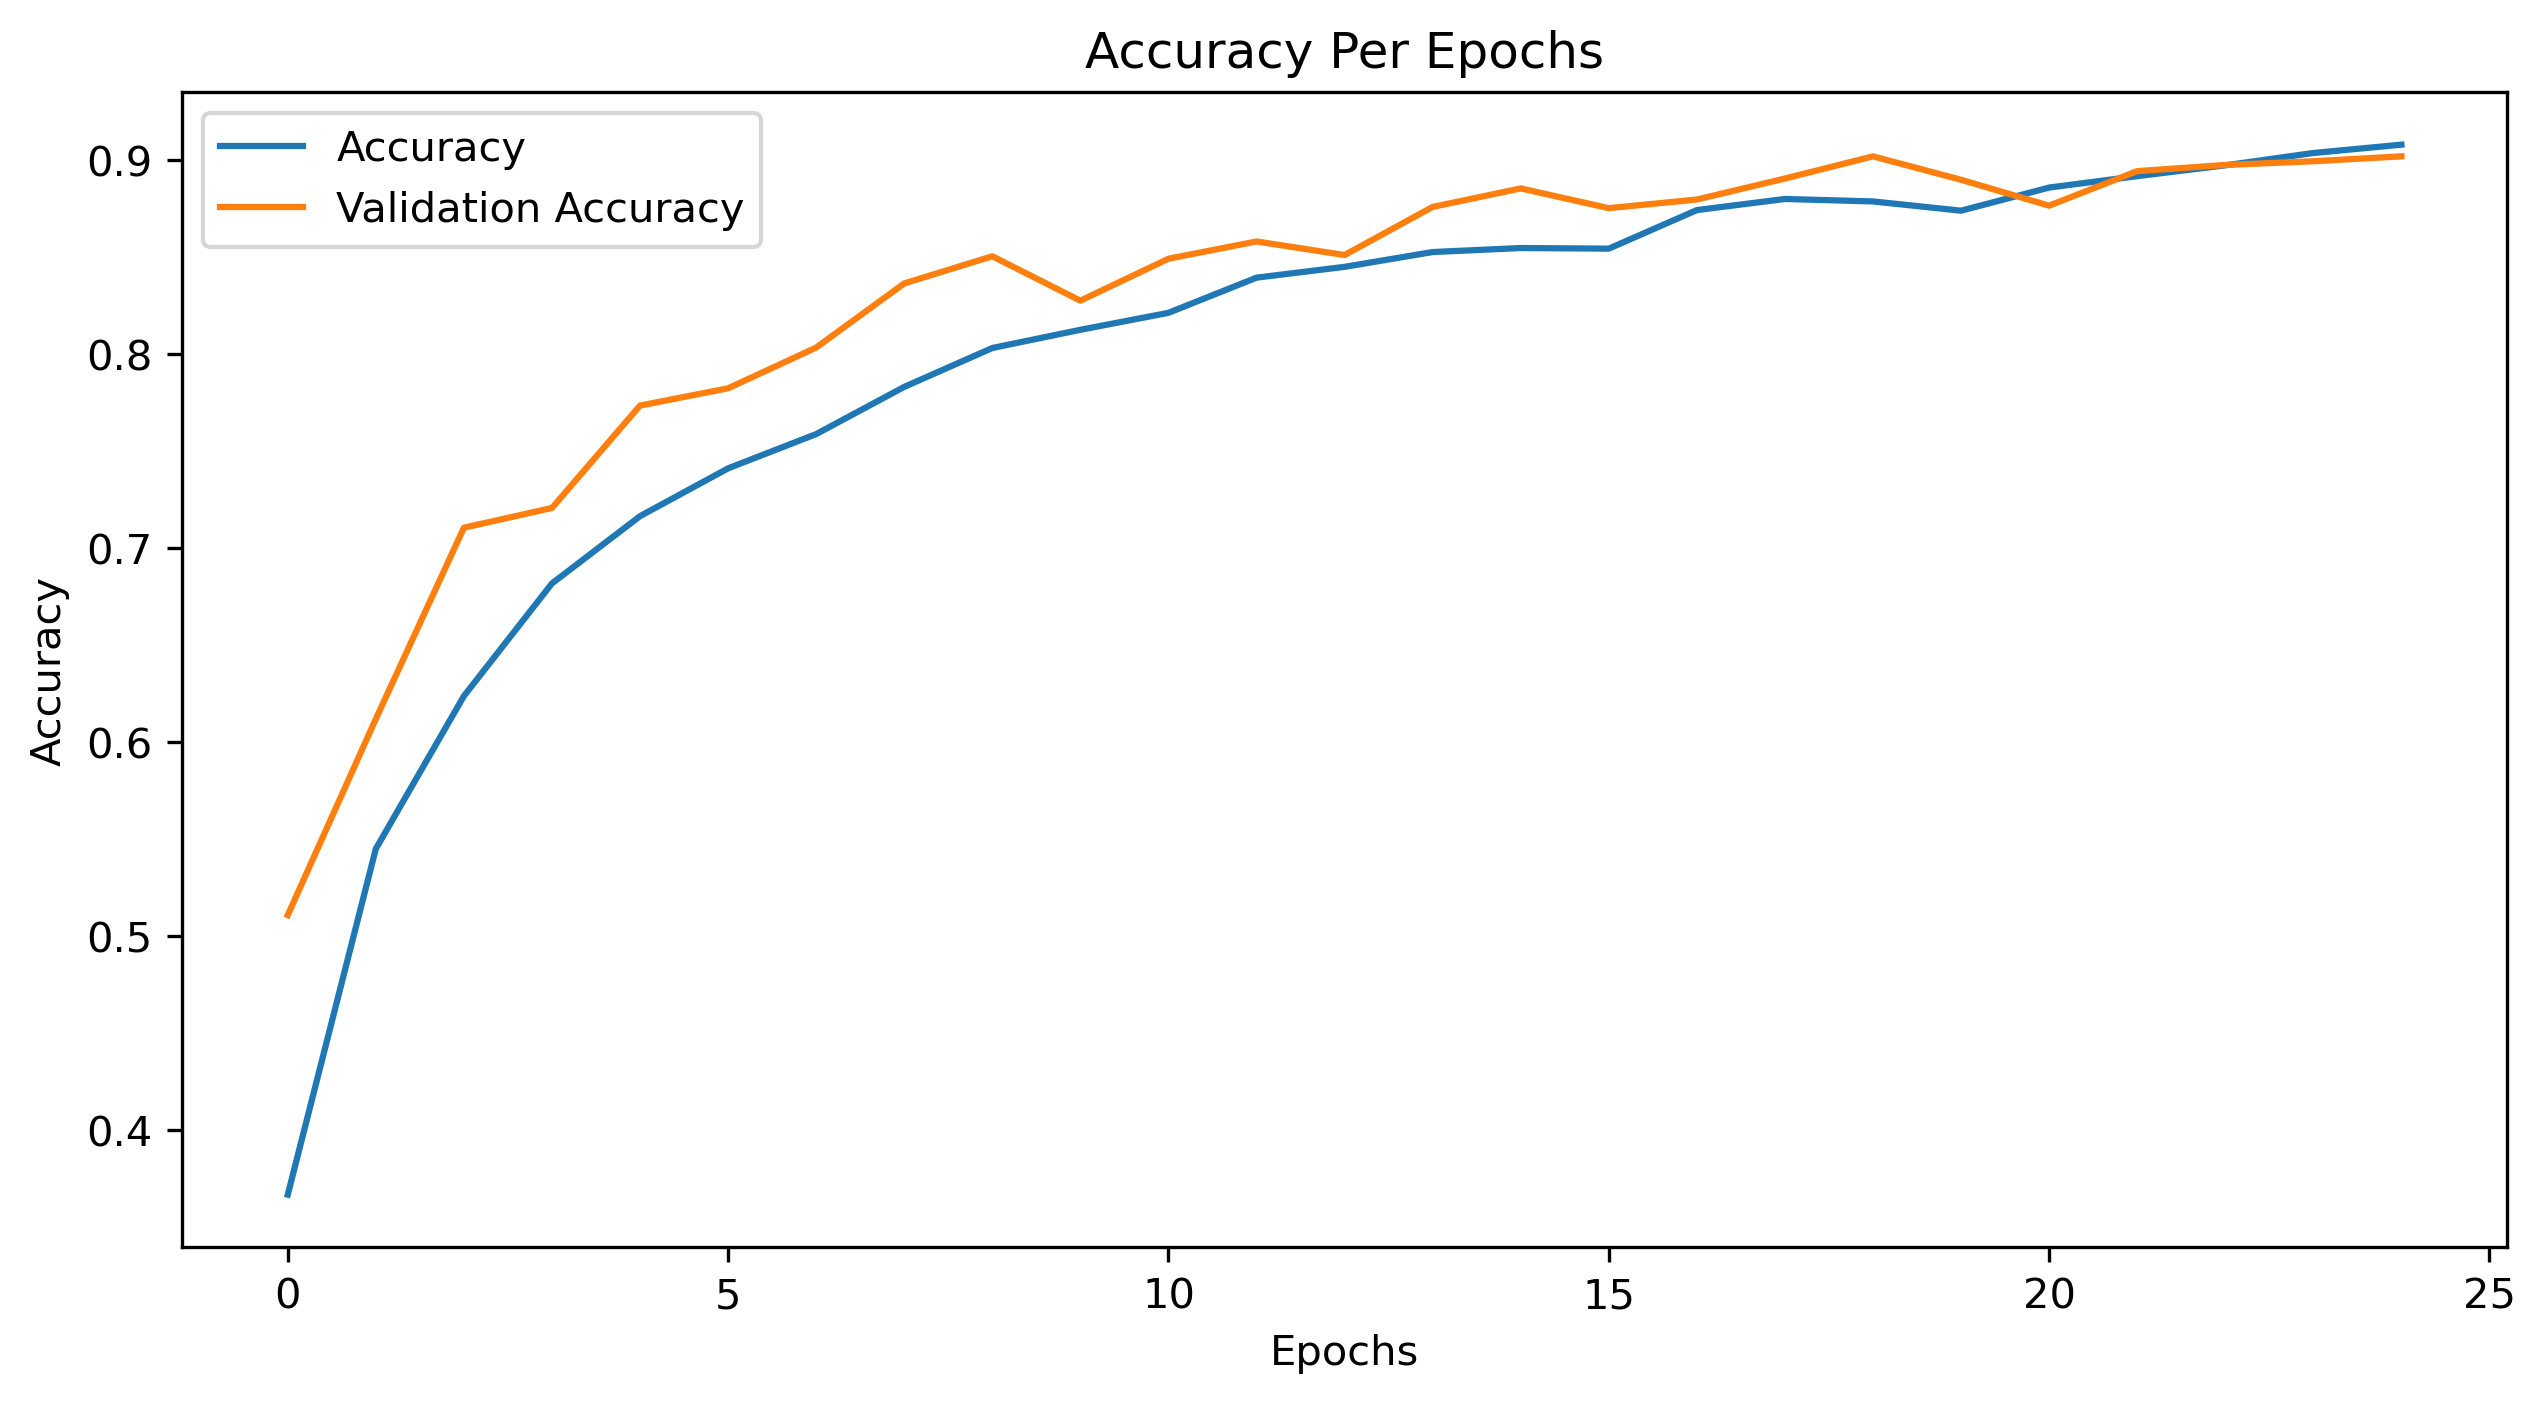

In [72]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [73]:
acc_m2 = CNN1D_Model.evaluate(xvalid, yvalid, verbose=0)
t0 = time.time()
y_pred_m2 = CNN1D_Model.predict(xvalid, verbose=0)
pred_m2 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN1D", acc_m2[1] * 100, train_m2, pred_m2]], columns=log_cols
)
log = log.append(log_entry)


## CNN1D Prediction Function


In [74]:
# function to predict the feature
def CNN1D_Prediction(file_name):
    # load the audio file
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    # get the feature
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128)
    # scale the features
    feature_scaled = np.mean(feature.T, axis=0)
    # array of features
    prediction_feature = np.array([feature_scaled])
    # expand dims
    final_prediction_feature = np.expand_dims(prediction_feature, axis=2)
    # get the id of label using argmax
    predicted_vector = np.argmax(CNN1D_Model.predict(final_prediction_feature), axis=-1)
    # get the class label from class id
    predicted_class = le.inverse_transform(predicted_vector)
    # display the result
    print("CNN1D has predicted the class as  --> ", predicted_class[0])


## Testing the Model on Sample audio


In [75]:
# File name
file_name = audio_dataset_path + "./fold8/103076-3-0-0.wav"
# get the output
CNN1D_Prediction(file_name)
# play the file
ipd.Audio(file_name)


1/1 [==============================] - 0s 47ms/step
CNN1D has predicted the class as  -->  Dog Bark


# **Comparative Analysis**


In [76]:
plt.rcParams["figure.figsize"] = (17, 2)
plt.rcParams["figure.dpi"] = 550


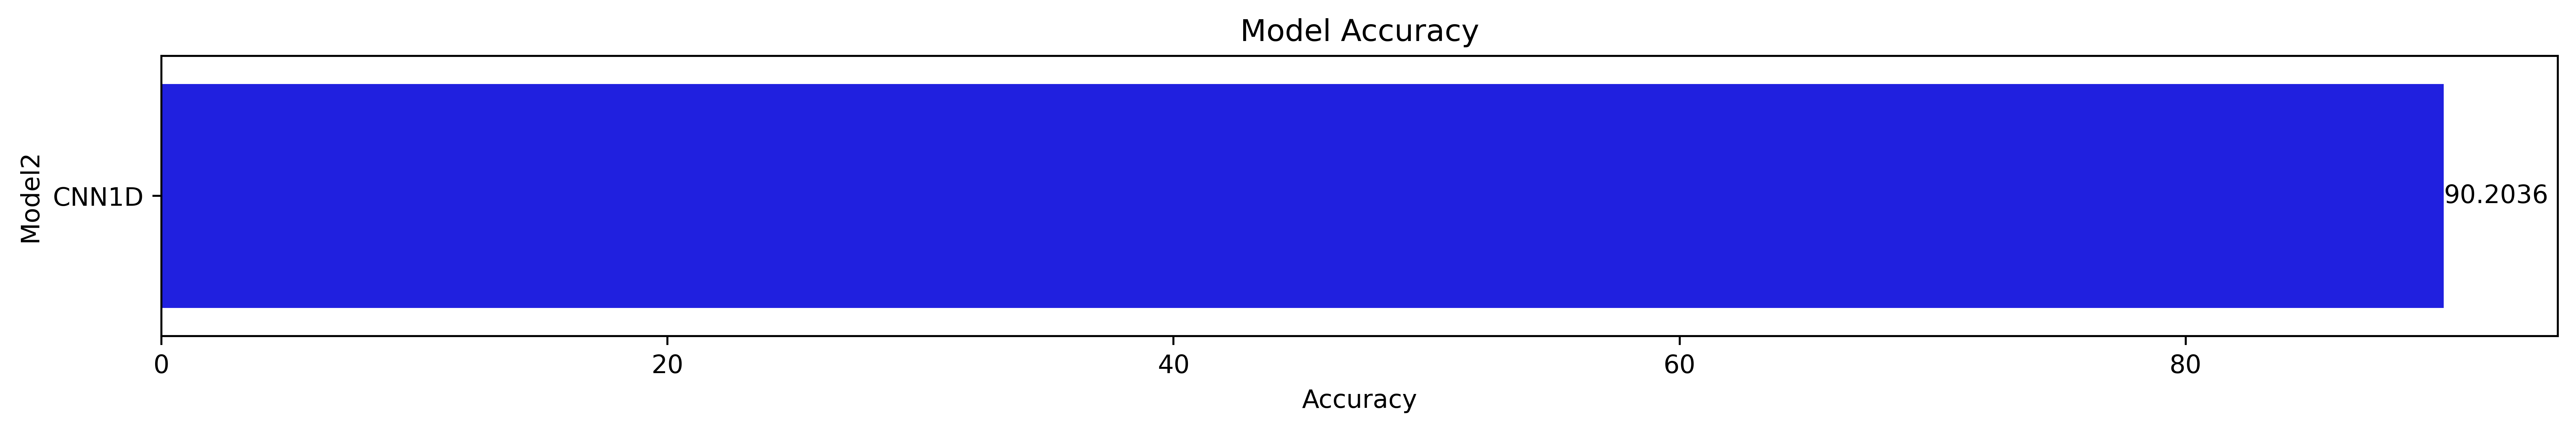

In [77]:
ax = sns.barplot(x="accuracy", y="model", data=log, color="b")
ax.bar_label(ax.containers[0])
plt.xlabel("Accuracy")
plt.ylabel("Model2")
plt.title("Model Accuracy")
plt.show()


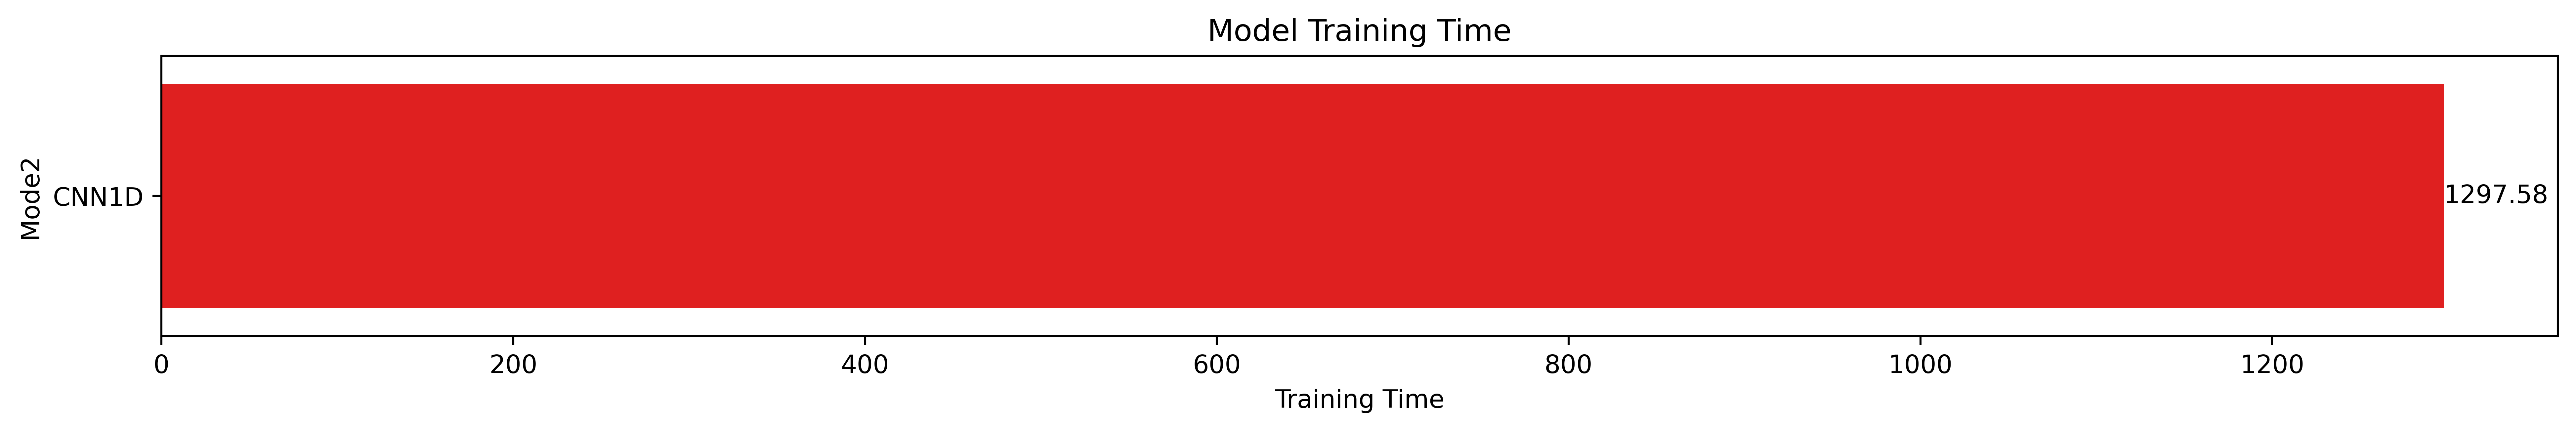

In [78]:
ax = sns.barplot(x="train_time", y="model", data=log, color="r")
ax.bar_label(ax.containers[0])
plt.xlabel("Training Time")
plt.ylabel("Mode2")
plt.title("Model Training Time")
plt.show()


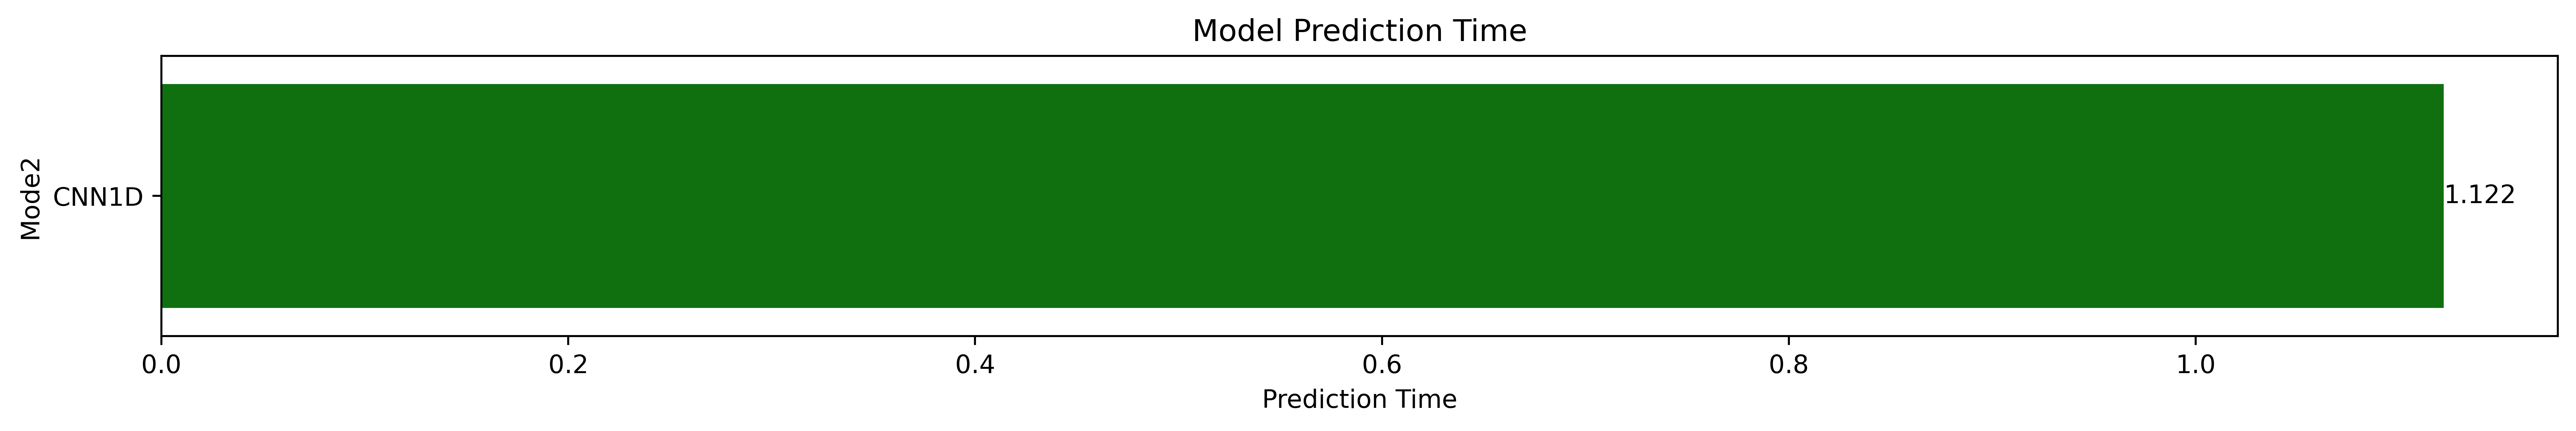

In [79]:
ax = sns.barplot(x="pred_time", y="model", data=log, color="g")
ax.bar_label(ax.containers[0])
plt.xlabel("Prediction Time")
plt.ylabel("Mode2")
plt.title("Model Prediction Time")
plt.show()
